In [1]:
# Imports
import numpy as np
import pandas as pd
import time
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from matplotlib.image import imread

from google.colab import drive
torch.manual_seed(1000)
# drive.mount('/content/gdrive')

from PIL import Image
import os


In [2]:
!apt-get install git -y
!git clone https://github.com/KevinGe00/Pneumonia-CNN-Classifier.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Cloning into 'Pneumonia-CNN-Classifier'...
remote: Enumerating objects: 7124, done.
remote: Counting objects: 100% (715/715), done.
remote: Compressing objects: 100% (708/708), done.
remote: Total 7124 (delta 6), reused 714 (delta 5), pack-reused 6409
Receiving objects: 100% (7124/7124), 139.70 MiB | 39.94 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (7130/7130), done.


In [3]:

# drive.mount('/content/gdrive')



import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler

# define the parent directory where the train and test subdirectories are located
# CHANGE THIS TO MATCH YOUR PARENT DIRECTORY
parent_dir = '/content/Pneumonia-CNN-Classifier/Data_new'

# define the data transformations to be applied to the images
train_transforms = transforms.Compose([
    transforms.Resize(size=224),
    transforms.RandomResizedCrop(size=224),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])





In [15]:

# Apply data augmentation techniques on dataset

######## train #############
train_data = datasets.ImageFolder(os.path.join(parent_dir, 'train'), transform=train_transforms)
# set color_mode to 'RGB'
train_data.color_mode = 'RGB'

# set class_mode to 'categorical'
train_data.class_mode = 'categorical'

# Calculate class frequency
class_freq = np.array([len(np.where(np.array(train_data.targets) == t)[0]) for t in range(len(train_data.classes))])
print(f'Class frequency wrt train: {class_freq}')

# Calculate class weights to balance class frequency
class_weights = 1.0 / torch.tensor(class_freq, dtype=torch.float)
print(f'Class weights wrt train: {class_weights}')

# Create sampler to be used in DataLoader
train_targets = torch.tensor(train_data.targets)
train_sampler = WeightedRandomSampler(weights=class_weights[train_targets], num_samples=len(train_targets), replacement=True)

# Confirm balanced class frequency
train_freqs_after_sampler = [0] * len(train_data.classes)
for idx in train_sampler:
    train_freqs_after_sampler[train_data.targets[idx]] += 1
print(f'Class frequency after weighting for training set: {train_freqs_after_sampler}')

train_loader = DataLoader(train_data, batch_size=32,sampler=train_sampler, num_workers=4)


# fix normalization for train data set
# Compute the mean and standard deviation values for each channel
mean = np.zeros(3)
std = np.zeros(3)
for images, _ in train_loader:
    for i in range(3):  # iterate over each channel
        channel_sum = images[:, i, :, :].sum()
        num_pixels = images[:, i, :, :].numel()
        mean[i] += channel_sum / num_pixels
        std[i] += ((images[:, i, :, :] - mean[i]) ** 2).sum() / num_pixels

mean /= len(train_loader)
std = np.sqrt(std / len(train_loader))

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

# Now, update the transformer

train_transforms = transforms.Compose([
    transforms.Resize(size=224),
    transforms.RandomResizedCrop(size=224),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])



train_data = datasets.ImageFolder(os.path.join(parent_dir, 'train'), transform=train_transforms)
train_loader = DataLoader(train_data, batch_size=32,sampler=train_sampler, num_workers=4)


###########################

####### test ###############
test_data = datasets.ImageFolder(os.path.join(parent_dir, 'test'), transform=test_transforms)
final_test_data = datasets.ImageFolder(os.path.join(parent_dir, 'test_final'), transform=test_transforms)
# set color_mode to 'RGB'
test_data.color_mode = 'RGB'
final_test_data.color_mode = 'RGB'

# set class_mode to 'categorical'
test_data.class_mode = 'categorical'
final_test_data.class_mode = 'categorical'
# Calculate class frequency
class_freq = np.array([len(np.where(np.array(test_data.targets) == t)[0]) for t in range(len(train_data.classes))])
print(f'Class frequency wrt test: {class_freq}')

# Calculate class weights to balance class frequency
class_weights = 1.0 / torch.tensor(class_freq, dtype=torch.float)
print(f'Class weights wrt test: {class_weights}')

# Create sampler to be used in DataLoader
test_targets = torch.tensor(test_data.targets)
test_sampler = WeightedRandomSampler(weights=class_weights[test_targets], num_samples=len(test_targets), replacement=True)

final_test_targets = torch.tensor(final_test_data.targets)
final_test_sampler = WeightedRandomSampler(weights=class_weights[final_test_targets], num_samples=len(final_test_targets), replacement=True)
# Confirm balanced class frequency
freqs = [0] * len(test_data.classes)
for idx in test_sampler:
    freqs[test_data.targets[idx]] += 1
print(f'Class frequency after weighting for test set: {freqs}')
test_loader = DataLoader(test_data, batch_size=32, sampler=test_sampler, num_workers=4)
final_test_loader = DataLoader(final_test_data, batch_size=32, sampler=final_test_sampler, num_workers=4)


#fix normalization for validation data set
# Compute the mean and standard deviation values for each channel
mean = np.zeros(3)
std = np.zeros(3)
for images, _ in test_loader:
    for i in range(3):  # iterate over each channel
        channel_sum = images[:, i, :, :].sum()
        num_pixels = images[:, i, :, :].numel()
        mean[i] += channel_sum / num_pixels
        std[i] += ((images[:, i, :, :] - mean[i]) ** 2).sum() / num_pixels

mean /= len(test_loader)
std = np.sqrt(std / len(test_loader))

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

# Now, update the transformer

test_transforms = transforms.Compose([
    transforms.Resize(size=224),
    transforms.RandomResizedCrop(size=224),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])



test_data = datasets.ImageFolder(os.path.join(parent_dir, 'test'), transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=32,sampler=test_sampler, num_workers=4)

############################







Class frequency wrt train: [ 460 1266 3419]
Class weights wrt train: tensor([0.0022, 0.0008, 0.0003])
Class frequency after weighting for training set: [1656, 1700, 1789]
Mean: [0.03336268 0.01061289 0.00072629]
Standard deviation: [3.08293087 0.98005006 0.06638197]
Class frequency wrt test: [116 317 855]
Class weights wrt test: tensor([0.0086, 0.0032, 0.0012])
Class frequency after weighting for test set: [449, 406, 433]
Mean: [0.05905529 0.18609855 0.41793898]
Standard deviation: [1.59742853 4.32592539 9.64676909]


# Exploratory statistical analysis



In [ ]:
# visualize images from each class
# I chose to do this on the training set

train_path = os.path.join(parent_dir, 'train')

covid_path = os.path.join(train_path, "COVID19")
pneumonia_path = os.path.join(train_path, "PNEUMONIA")
normal_path = os.path.join(train_path, "NORMAL")




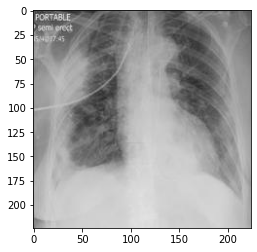

In [ ]:
covid_sample = os.listdir(covid_path)[0]
plt.imshow(imread(os.path.join(covid_path, covid_sample)))

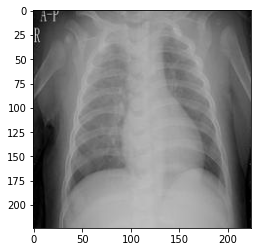

In [ ]:
pneumonia_sample = os.listdir(pneumonia_path)[0]
plt.imshow(imread(os.path.join(pneumonia_path, pneumonia_sample)))

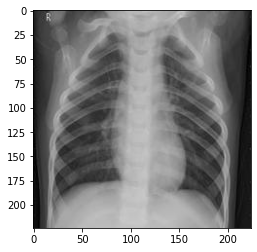

In [ ]:
normal_sample = os.listdir(normal_path)[0]
plt.imshow(imread(os.path.join(normal_path, normal_sample)))

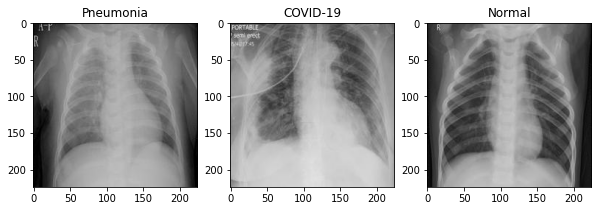

In [ ]:
# Create figure with three subplots in a row
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot each image in a separate subplot
axs[0].imshow(imread(os.path.join(pneumonia_path, pneumonia_sample)))
axs[1].imshow(imread(os.path.join(covid_path, covid_sample)))
axs[2].imshow(imread(os.path.join(normal_path, normal_sample)))

# Set title for each subplot
axs[0].set_title('Pneumonia')
axs[1].set_title('COVID-19')
axs[2].set_title('Normal')

# Display the figure
plt.show()

[ 460 1266 3419]


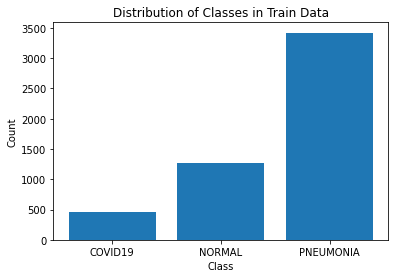

In [ ]:
# Exploratory statistical analysis

# Get class names and counts
class_names = train_data.classes
class_counts = np.bincount(train_data.targets)
print(class_counts)

# Create bar chart for training data distrib b4 apply weighted sampler
fig, ax = plt.subplots()
ax.bar(class_names, class_counts)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes in Train Data')
plt.show()


from torchvision.transforms import ToPILImage





In [ ]:
#  Compute mean and standard deviation of ALL images( no sampler applied)
mean = 0.0
std = 0.0
to_pil = ToPILImage()
for img, _ in train_data:
    img = to_pil(img)  # Convert tensor to PIL Image
    mean += torch.mean(TF.to_tensor(img))
    std += torch.std(TF.to_tensor(img))

mean /= len(train_data)
std /= len(train_data)

print(f'Mean: {mean:.4f}, Std: {std:.4f}')

Mean: 0.5046, Std: 0.2972


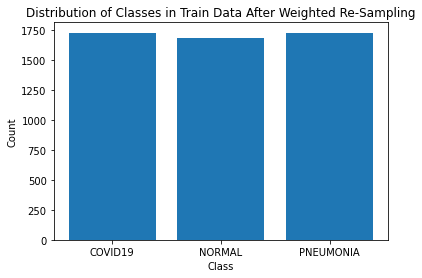

In [ ]:
# Exploratory statistical analysis

class_names = train_data.classes


# Create bar chart for training data distrib after apply weighted sampler
fig, ax = plt.subplots()
ax.bar(class_names, train_freqs_after_sampler)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes in Train Data After Weighted Re-Sampling')
plt.show()


# Separate code and import for baseline model

In [ ]:
!apt-get install git -y
!git clone https://github.com/KevinGe00/Pneumonia-CNN-Classifier.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Cloning into 'Pneumonia-CNN-Classifier'...
remote: Enumerating objects: 6430, done.
remote: Counting objects: 100% (6430/6430), done.
remote: Compressing objects: 100% (6426/6426), done.
remote: Total 6430 (delta 6), reused 6417 (delta 1), pack-reused 0
Receiving objects: 100% (6430/6430), 40.96 MiB | 21.41 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn import svm, metrics

# Define the paths to the train and test datasets
train_path = '/content/Pneumonia-CNN-Classifier/Data_new/train'
test_path = '/content/Pneumonia-CNN-Classifier/Data_new/test'

# Load the training images and their labels
train_data = []
train_labels = []
for class_label in os.listdir(train_path):
    if os.path.isdir(os.path.join(train_path, class_label)):
        for filename in os.listdir(os.path.join(train_path, class_label)):
            if filename.endswith('.jpg'):
                img_path = os.path.join(train_path, class_label, filename)
                img = Image.open(img_path)
                train_data.append(np.array(img).reshape(-1))
                train_labels.append(class_label)
                
# Convert the training data and labels to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Load the testing images and their labels
test_data = []
test_labels = []
for class_label in os.listdir(test_path): # COVID19, NORMAL, PNEUMONIA
    if os.path.isdir(os.path.join(test_path, class_label)):
        for filename in os.listdir(os.path.join(test_path, class_label)):
            if filename.endswith('.jpg'):
                img_path = os.path.join(test_path, class_label, filename)
                img = Image.open(img_path)
                test_data.append(np.array(img).reshape(-1))
                test_labels.append(class_label)
                
# Convert the testing data and labels to numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Define the SVM classifier
clf = svm.SVC(kernel='linear', C=1, decision_function_shape='ovr')

# Train the classifier using the training data
clf.fit(train_data, train_labels)

# Predict the classes of the test data
y_pred = clf.predict(test_data)

# Print the classification report
print(metrics.classification_report(test_labels, y_pred))

# Primary Model
Run Kai's data augmentation cells first, to obtain train_loader and test_loader. Test loader is actually our valid_loader, we'll talk about changing the variable names later


In [7]:
# add imports needed for primary model and training
# doesnt matter if duplicated from above, this is more
# transparent
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

In [8]:
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(1024 * 7 * 7, 10)
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        x = x.view(-1, 1024 * 7 * 7) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def get_model_path(num_epochs, lr, comment=""):
    path = f"model_{num_epochs}_{lr}"
    if comment:
      path += "_" + comment
    return path

In [10]:
from torchvision.models.densenet import densenet121
# Load the pre-trained densenet121 model
densenet = models.densenet121(pretrained=True)

# Freeze all the layers in the pre-trained model
for param in densenet.parameters():
    param.requires_grad = False

 
''''num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 2)
)'''
#early dropout
#dropout_prob = 0.5
#densenet.features.add_module("dropout", nn.Dropout(p=dropout_prob))

# Move densenet to the GPU (if available)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet.to(DEVICE)


def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        output = model(densenet.features(imgs))
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# Define the training loop, using densenet defined above
def train_model(model, train_loader, valid_loader, num_epochs=20, lr=0.001, batch_size=32, checkpoint_path='', comment=""):
    print(f"Starting training on device: {DEVICE}")
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Variables for logging
    iters, losses, train_acc, valid_acc = [], [], [], []
    best_valid_acc = 0.0
    num_iter = 0
    start_time=time.time()

    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)  # enable GPU if available
            outputs = model(densenet.features(inputs))  # go through densenet's CNN first before passing output to our model
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy. We don't compute accuracy on the whole training set in every iteration!
            pred = outputs.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = inputs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))

            # Log 
            iters.append(num_iter)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            valid_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy

            num_iter += 1
            mini_b += 1
            print("Iteration: ",num_iter,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time), "Train Acc: % 6.2f " % train_acc[-1], "Valid Acc: % 6.2f " % valid_acc[-1])
        
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

        # Save model if best so far
        if valid_acc[-1] > best_valid_acc:
          best_valid_acc = valid_acc[-1]
          model_path = get_model_path(num_epochs, lr, comment)
          torch.save(model.state_dict(), model_path)


    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Train Acc: ", train_acc[-1])
    print("Final Val Acc: ", valid_acc[-1])


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
# Find the output of densenet, so we can configure input of our ANN above accordingly
# You don't have to run this, it's only to help me set up our model
# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# features = densenet.features(images)
# features.shape  # this output is what the ANN should receive

In [11]:
dataiter = iter(train_loader)
for images, labels in dataiter:
  # features = densenet.features(images)
  print(images.shape)  # this output is what the ANN should receive

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size

In [ ]:
torch. cuda. is_available()

True

Starting training on device: cuda
Iteration:  1 Progress:   0.21  % Time Elapsed:   6.63 s  Train Acc:   0.47  Valid Acc:   0.35 
Iteration:  2 Progress:   0.41  % Time Elapsed:  14.22 s  Train Acc:   0.25  Valid Acc:   0.40 
Iteration:  3 Progress:   0.62  % Time Elapsed:  20.06 s  Train Acc:   0.41  Valid Acc:   0.45 
Iteration:  4 Progress:   0.83  % Time Elapsed:  26.92 s  Train Acc:   0.53  Valid Acc:   0.43 
Iteration:  5 Progress:   1.04  % Time Elapsed:  32.68 s  Train Acc:   0.53  Valid Acc:   0.45 
Iteration:  6 Progress:   1.24  % Time Elapsed:  39.47 s  Train Acc:   0.22  Valid Acc:   0.43 
Iteration:  7 Progress:   1.45  % Time Elapsed:  45.20 s  Train Acc:   0.34  Valid Acc:   0.44 
Iteration:  8 Progress:   1.66  % Time Elapsed:  51.90 s  Train Acc:   0.47  Valid Acc:   0.43 
Iteration:  9 Progress:   1.86  % Time Elapsed:  57.59 s  Train Acc:   0.53  Valid Acc:   0.43 
Iteration:  10 Progress:   2.07  % Time Elapsed:  63.91 s  Train Acc:   0.34  Valid Acc:   0.48 
Itera

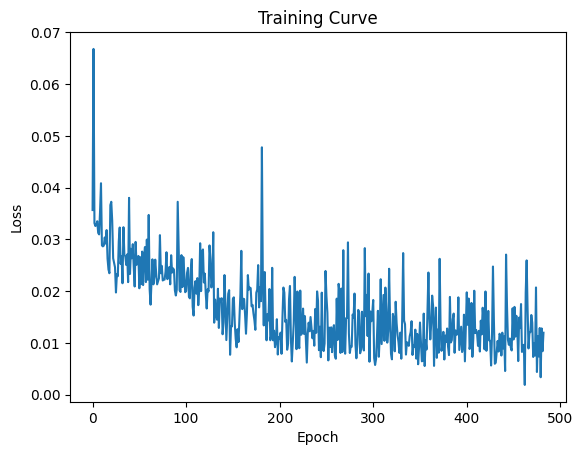

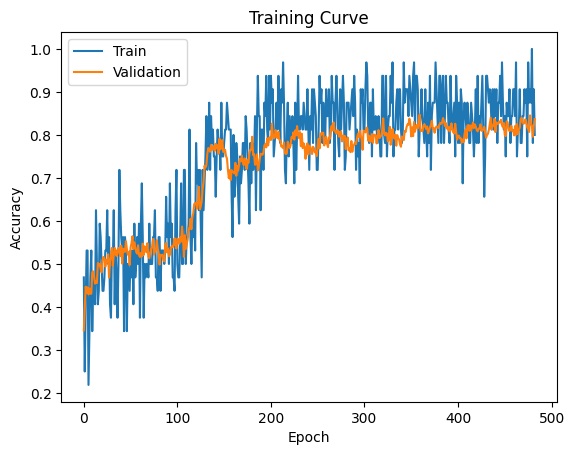

Final Train Acc:  0.8
Final Val Acc:  0.8369565217391305


In [16]:
# Train the model
model = ANNClassifier()
model.to(DEVICE)
# def train_model(model, train_loader, valid_loader, num_epochs=20, lr=0.001, batch_size=32, checkpoint_path='', comment=""):
train_model(model, train_loader, test_loader, num_epochs=3, batch_size= 32)

In [12]:
def get_accuracy_depth(model, data_loader):
    correct = [0, 0, 0]  
    total = [0, 0, 0]  
    for imgs, labels in data_loader:
       # print(imgs)
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        output = model(densenet.features(imgs))
        pred = output.max(1, keepdim=True)[1]
        for i in range(len(labels)):
            #print(labels[i])
            if pred[i] == labels[i]:
                correct[labels[i]] += 1
            total[labels[i]] += 1
    accuracy = [c/t for c, t in zip(correct, total)]
    return accuracy


In [13]:
print(get_accuracy_depth(model, final_test_loader))
print(get_accuracy_depth(model, test_loader))

NameError: ignored